In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

sys.path.append(os.path.abspath("../"))

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from tqdm import tqdm

from synthdid.model import SynthDID
from synthdid.sample_data import fetch_CaliforniaSmoking

In [2]:
df = fetch_CaliforniaSmoking()

PRE_TEREM = [1970, 1988]
POST_TEREM = [1989, 2000]

TREATMENT = ["California"]

sdid = SynthDID(df, PRE_TEREM, POST_TEREM, TREATMENT)


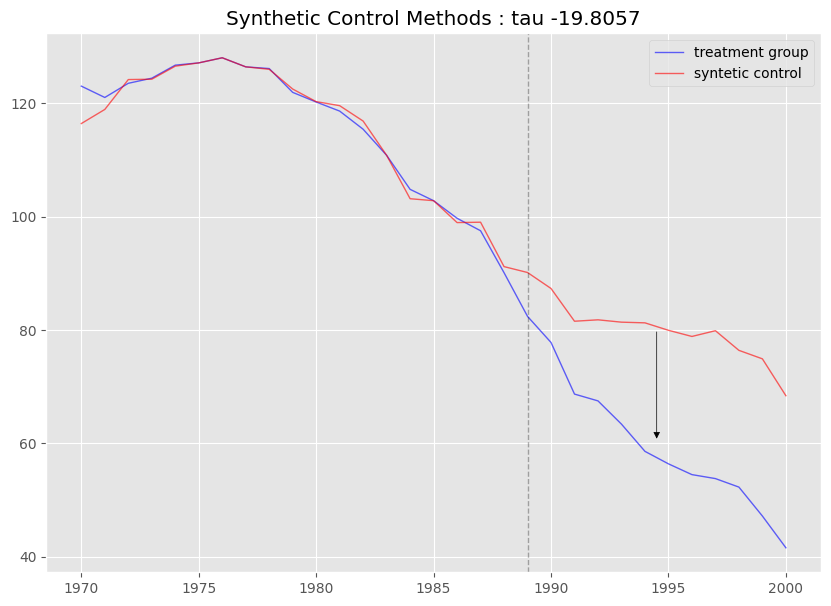

In [3]:
sdid.fit(zeta_type="base", simple_sc=True)
hat_omega_simple = sdid.estimated_params(model="sc")
sdid.plot(model="sc")

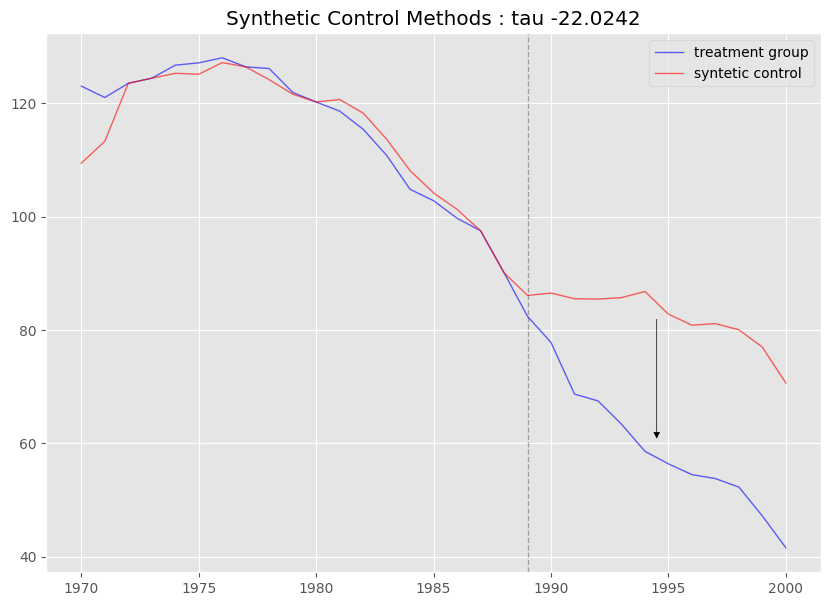

In [4]:
sdid.fit(zeta_type="base", simple_sc=False)
hat_omega_classic = sdid.estimated_params(model="sc")
sdid.plot(model="sc")

In [5]:
omega_result = pd.merge(
    hat_omega_simple.rename(columns={"sc_weight" : "smple_weight"}),
    hat_omega_classic.rename(columns={"sc_weight" : "classic_weight"}),
    on = "features",
    how="left"
)
omega_result.sum()

features          AlabamaArkansasColoradoConnecticutDelawareGeor...
smple_weight                                                    1.0
classic_weight                                                0.998
dtype: object

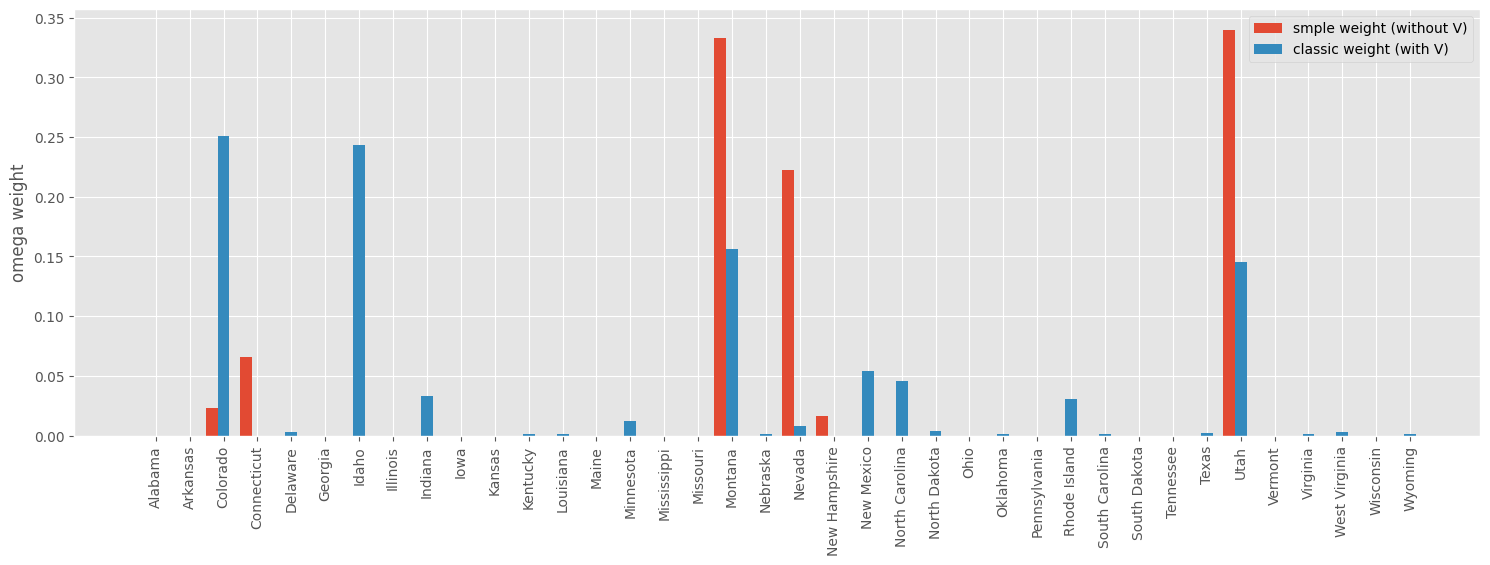

In [6]:
fig = plt.figure()
fig.set_figwidth(15)
ax = fig.add_subplot(1, 1, 1)
width = 0.35
ind = np.arange(len(omega_result))
ax.bar(ind - width, omega_result["smple_weight"], width, label="smple weight (without V)")
ax.bar(ind, omega_result["classic_weight"], width, label="classic weight (with V)")

ax.set_xticks(ind)
ax.set_xticklabels(omega_result["features"].values)
ax.legend()
ax.set_ylabel("omega weight")

fig.tight_layout()
plt.xticks(rotation=90)
plt.show()

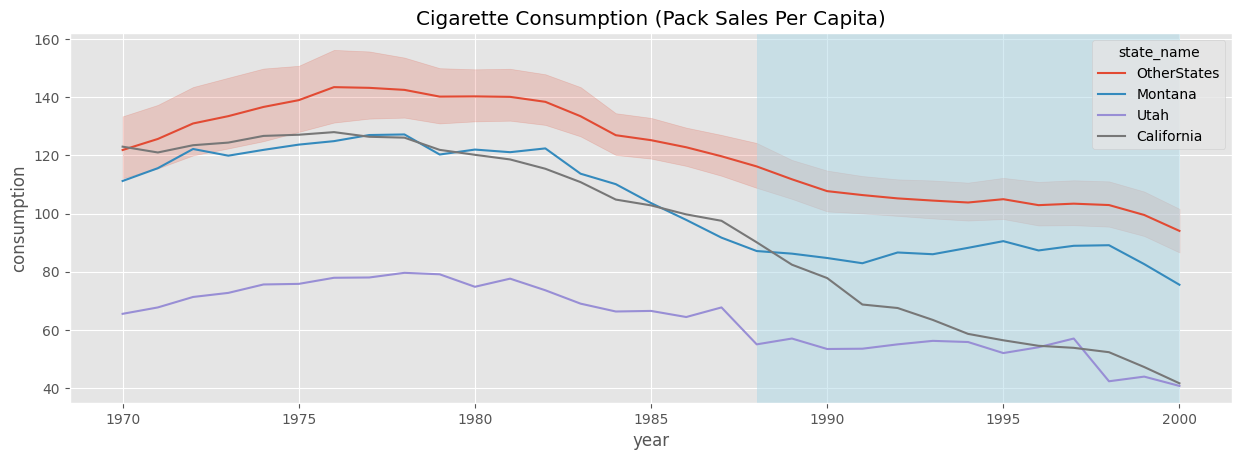

In [7]:
melt_df = pd.melt(
    df.reset_index().rename(columns={"index": "year"}),
    id_vars="year",
    value_name="consumption",
    var_name="state",
)
melt_df["state_name"] = np.where( melt_df["state"] == "California", "California", "OtherStates")
melt_df.loc[melt_df["state"] == "Utah", "state_name"] =  "Utah"
melt_df.loc[melt_df["state"] == "Montana", "state_name"] =  "Montana"

fig, ax = plt.subplots()
fig.set_figwidth(15)

sns.lineplot(x="year", y="consumption", hue="state_name", data=melt_df, ax=ax)

ax.axvspan(1988, 2000, alpha=0.5, color="lightblue")

plt.title("Cigarette Consumption (Pack Sales Per Capita)")
plt.show()

## test 1 : Utah with simple

In [8]:
expand_list = [0.01, 0.1, 0.5, 0.8, 1, 1.2, 1.5, 2, 10, 50, 100]

In [9]:
utah_omega = {}
utah_tau = {}

for _e in tqdm(expand_list):
    _df = df.copy()
    _df["Utah"] = _df["Utah"] * _e
    # re-run
    _sdid = SynthDID(_df, PRE_TEREM, POST_TEREM, TREATMENT)
    _sdid.fit(zeta_type="base")

    utah_tau[_e] = _sdid.hat_tau(model="sc")
    hat_omega_sc = _sdid.estimated_params(model="sc")
    utah_omega[_e] = hat_omega_sc.query("features == 'Utah'")[
        "sc_weight"
    ].values[0]

100%|██████████| 11/11 [00:36<00:00,  3.35s/it]


In [10]:
utah_tau = pd.DataFrame(utah_tau, index = ["tau"]).T
utah_omega = pd.DataFrame(utah_omega, index = ["weight"]).T

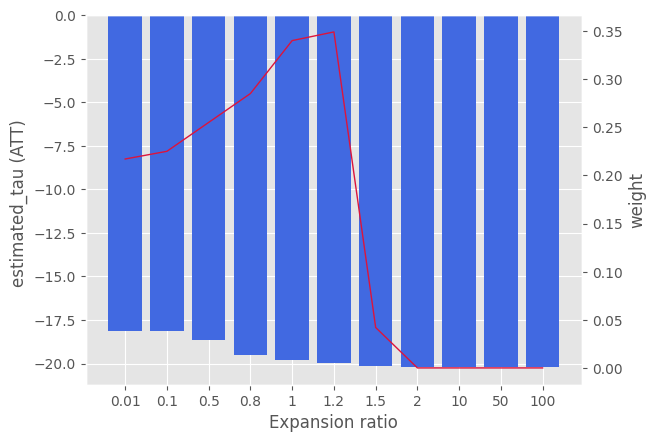

In [11]:
_expand_list = [ str(_e) for _e in expand_list ]

fig, ax1 = plt.subplots()
ax1.bar(_expand_list , utah_tau["tau"], align="center", color="royalblue", linewidth=0, label="tau")
ax1.set_ylabel('estimated_tau (ATT) ')
ax1.set_xlabel('Expansion ratio')
 
ax2 = ax1.twinx()
ax2.plot(_expand_list , utah_omega["weight"], linewidth=1, color="crimson", label="weight")
ax2.set_ylabel('weight')
ax2.grid(False)

plt.show()

In [12]:
utah_tau.T

,0.01,0.10,0.50,0.80,1.00,1.20,1.50,2.00,10.00,50.00,100.00
tau,-18.143495,-18.140818,-18.674385,-19.523926,-19.805718,-19.989381,-20.147111,-20.206209,-20.198311,-20.199457,-20.196539


In [13]:
utah_tau.std()

tau    0.83871
dtype: float64

In [14]:
utah_omega.T

,0.01,0.10,0.50,0.80,1.00,1.20,1.50,2.00,10.00,50.00,100.00
weight,0.217,0.225,0.255,0.285,0.34,0.349,0.042,0.0,0.0,0.0,0.0


## test 1 : Utah with classic

In [15]:
utah_omega = {}
utah_tau = {}

for _e in tqdm(expand_list):
    _df = df.copy()
    _df["Utah"] = _df["Utah"] * _e
    # re-run
    _sdid = SynthDID(_df, PRE_TEREM, POST_TEREM, TREATMENT)
    _sdid.fit(zeta_type="base", simple_sc=False)

    utah_tau[_e] = _sdid.hat_tau(model="sc")
    hat_omega_sc = _sdid.estimated_params(model="sc")
    utah_omega[_e] = hat_omega_sc.query("features == 'Utah'")[
        "sc_weight"
    ].values[0]

100%|██████████| 11/11 [00:37<00:00,  3.38s/it]


In [16]:
utah_tau = pd.DataFrame(utah_tau, index = ["tau"]).T
utah_omega = pd.DataFrame(utah_omega, index = ["weight"]).T

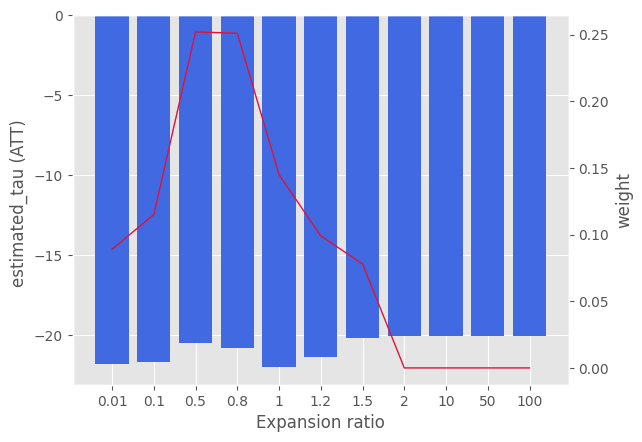

In [17]:
_expand_list = [ str(_e) for _e in expand_list ]

fig, ax1 = plt.subplots()
ax1.bar(_expand_list , utah_tau["tau"], align="center", color="royalblue", linewidth=0, label="tau")
ax1.set_ylabel('estimated_tau (ATT) ')
ax1.set_xlabel('Expansion ratio')
 
ax2 = ax1.twinx()
ax2.plot(_expand_list , utah_omega["weight"], linewidth=1, color="crimson", label="weight")
ax2.set_ylabel('weight')
ax2.grid(False)

plt.show()

In [18]:
utah_tau.T

,0.01,0.10,0.50,0.80,1.00,1.20,1.50,2.00,10.00,50.00,100.00
tau,-21.847578,-21.698186,-20.522952,-20.842262,-22.024231,-21.407201,-20.219519,-20.100814,-20.100818,-20.100705,-20.100806


In [19]:
utah_tau.std()

tau    0.783596
dtype: float64

In [20]:
utah_omega.T

,0.01,0.10,0.50,0.80,1.00,1.20,1.50,2.00,10.00,50.00,100.00
weight,0.089,0.115,0.252,0.251,0.145,0.099,0.078,0.0,0.0,0.0,0.0
